Try with Potts instead of indep sites

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
import random

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS", "R02N"]

dtype = torch.float32

In [3]:
sequences = []
for round_id in round_ids:
    sequences.append(utils.sequences_from_file(experiment_id, round_id))
    print(f"Finished round {round_id}")

Finished round ARN
Finished round R01
Finished round R01CS
Finished round R02N


In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [5]:
sequences.clear()

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [39]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [40]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype) * 1e-4
h_beads = torch.randn(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4
J = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor(
    [[1, 1, 0],
     [0, 1, 0],
     [1, 1, 0]]
)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
# indep = energy_models.IndepSites(h)
beads = energy_models.IndepSites(h_beads)
unbound_sel = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(potts, beads, unbound_sel, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [41]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [42]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype).to(device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype).to(device)

In [43]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
max_epochs = 3000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               callbacks=callbacks, log_weights=log_weights, lr=lr)

 0.00%[                                                                                                       …

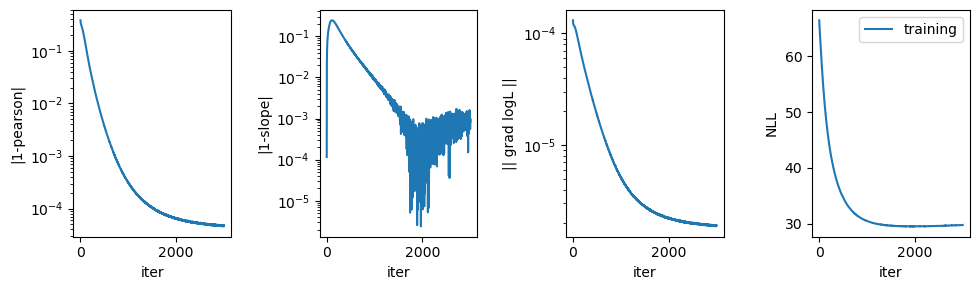

In [68]:
callbacks[0].plot();

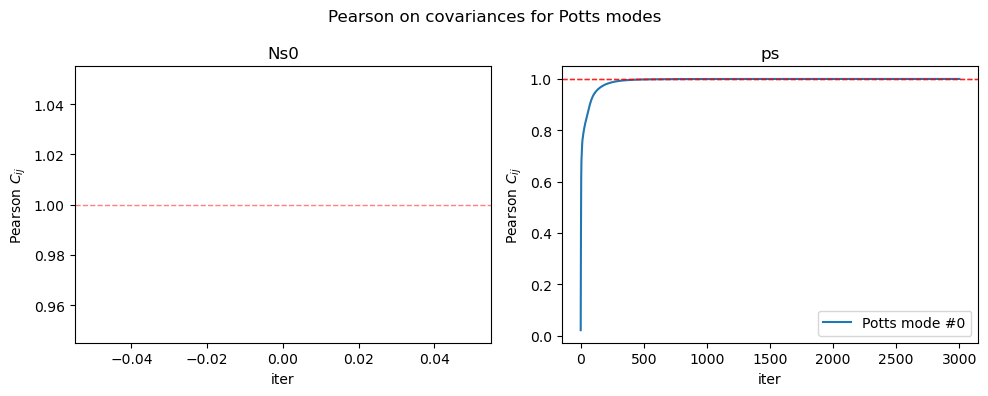

In [69]:
callbacks[1].plot();

<IPython.core.display.Latex object>

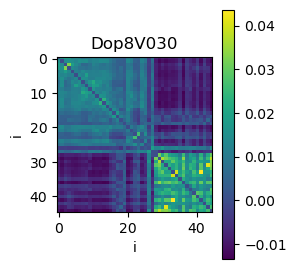

In [70]:
from IPython.display import display, Latex

potts_zerosum = model.selection.modes[0].set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach().cpu())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [ ]:
# torch.save(model.to(torch.device('cpu')), 'experiments/saved/dataset_1_beads.pt')

In [ ]:
# h_norm_bead = torch.sqrt(torch.square(potts_zerosum.h.cpu().detach().clone()).sum(1))
# plt.scatter(range(L), h_norm_bead)

## Same thing but without the info from the control round

In [ ]:
L, q = sequences_oh[0][0].shape
n_rounds_noc = 3

k_noc = torch.randn(L, q, dtype=dtype) * 1e-4
h_beads_noc = torch.randn(L, q, dtype=dtype) * 1e-4
h_noc = torch.randn(L, q, dtype=dtype) * 1e-4
J_noc = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

tr_noc = tree.Tree()
tr_noc.add_node(-1)
tr_noc.add_node(0)

selected_modes_noc = torch.BoolTensor(
    [[1, 0],
     [1, 0]]
)

Ns0_noc = energy_models.IndepSites(k_noc)
# indep_noc = energy_models.IndepSites(h_noc)
potts_noc = energy_models.Potts(J_noc, h_noc)
unbound_sel_noc = energy_models.ConstantEnergy(-10)

ps_noc = selex_distribution.MultiModeDistribution(potts_noc, unbound_sel_noc, normalized=True)
model_noc = selex_distribution.MultiRoundDistribution(Ns0_noc, ps_noc, tr_noc, selected_modes_noc).to(device)

Here we only select for unbound and target, and do not use the control round

In [ ]:
total_reads_noc = torch.Tensor([sequences_oh[t].shape[0] for t in [0,1,3]]).to(device)

In [ ]:
# device = torch.device('cpu')

In [ ]:
batch_size = 10**6
data_loaders_noc = [data_loading.SelexRoundDataLoader(sequences_oh[t], batch_size=batch_size, device=device) for t in [0,1,3]]
# n_rounds = len(data_loaders_noc) 

In [ ]:
n_chains = 10**5
chains_noc = training.init_chains(n_rounds_noc, n_chains, L, q, dtype=dtype).to(device)
log_weights_noc = torch.zeros(n_rounds_noc, n_chains, dtype=dtype).to(device)

In [ ]:
callbacks_noc = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
max_epochs = 3000

training.train(model_noc, data_loaders_noc, total_reads_noc, chains_noc, n_sweeps, max_epochs, 
               callbacks=callbacks_noc, log_weights=log_weights_noc, lr=lr)

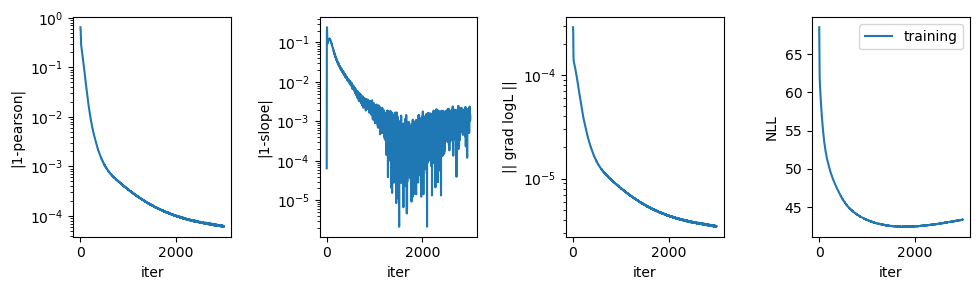

In [71]:
callbacks_noc[0].plot();

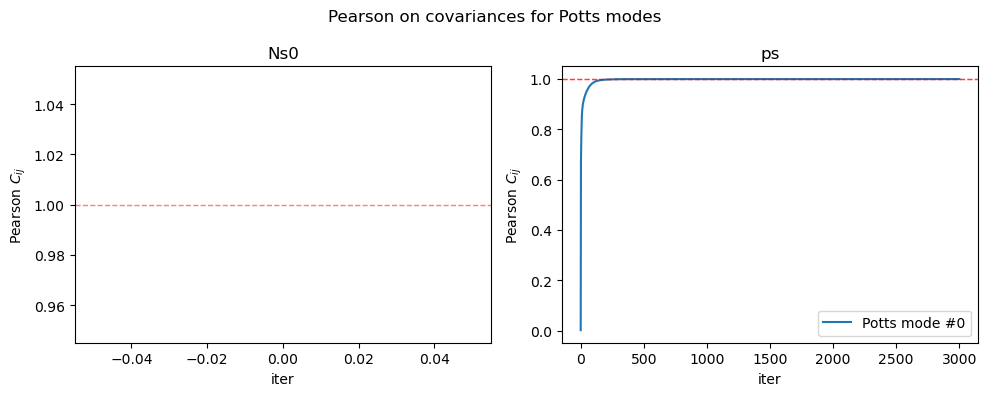

In [72]:
callbacks_noc[1].plot();

<IPython.core.display.Latex object>

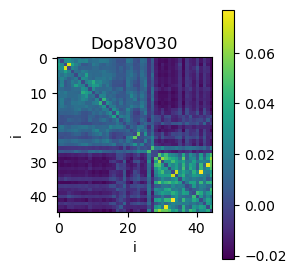

In [73]:
from IPython.display import display, Latex

potts_zerosum = model_noc.selection.modes[0].set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach().cpu())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [74]:
# torch.save(model_noc.to(torch.device('cpu')), 'experiments/saved/dataset_1_nobeads.pt')

## Comparison

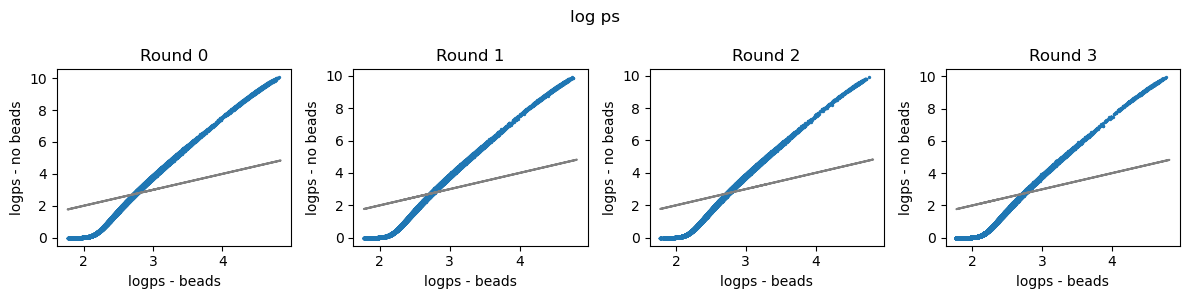

In [75]:
N = 10**5
n_sel = model.get_n_rounds()
fig, axes = plt.subplots(1, n_sel, figsize=(12,3))

for t in range(n_sel):
    X = sequences_oh[t]
    x = model_cpu.selection_energy_at_round(X, 1).detach()
    y = model_noc_cpu.selection_energy_at_round(X, 1).detach()
    idx = random.sample(range(len(x)), N)
    ax = axes[t]
    ax.plot(x, x, color='gray')
    ax.scatter(x[idx], y[idx], s=2)
    ax.set_xlabel('logps - beads')
    ax.set_ylabel('logps - no beads')
    ax.set_title(f'Round {t}')
fig.suptitle('log ps')
fig.tight_layout();

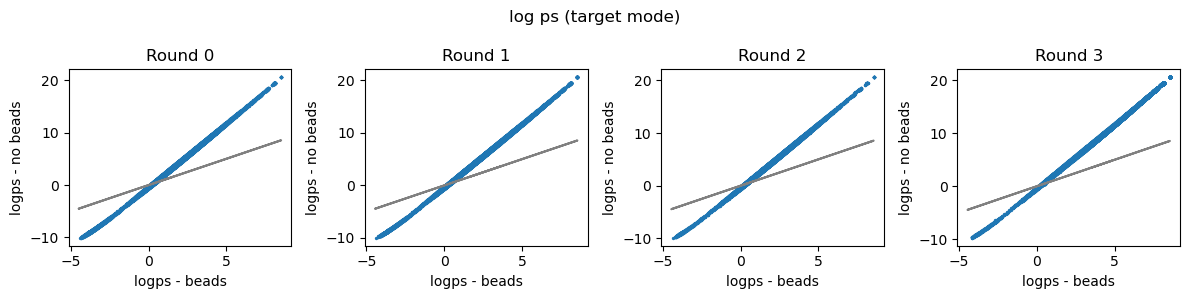

In [91]:
N = 10**5
n_sel = model.get_n_rounds()
fig, axes = plt.subplots(1, n_sel, figsize=(12,3))

for t in range(n_sel):
    X = sequences_oh[t]
    x = - model_cpu.selection.modes[0].compute_energy(X).detach()
    y = - model_noc_cpu.selection.modes[0].compute_energy(X).detach()
    idx = random.sample(range(len(x)), N)
    ax = axes[t]
    ax.plot(x, x, color='gray')
    ax.scatter(x[idx], y[idx], s=2)
    ax.set_xlabel('logps - beads')
    ax.set_ylabel('logps - no beads')
    ax.set_title(f'Round {t}')
fig.suptitle('log ps (target mode)')
fig.tight_layout();

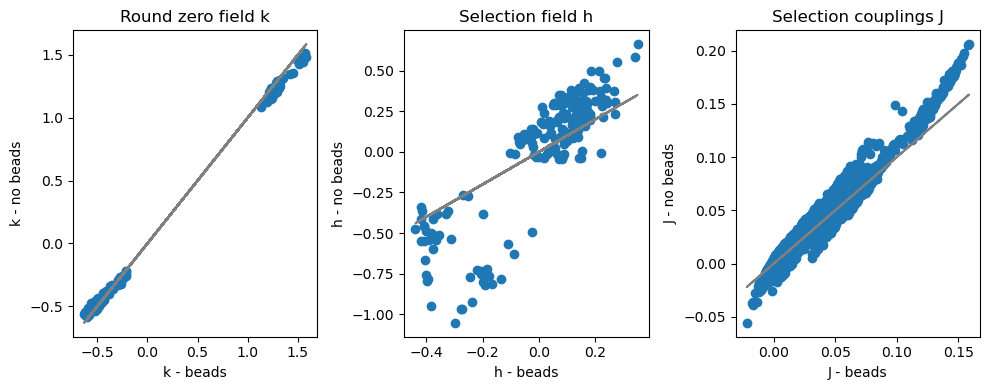

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

ax = axes[0]
x = model.round_zero.set_zerosum_gauge().h.detach().cpu()
y = model_noc.round_zero.set_zerosum_gauge().h.detach().cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('k - beads')
ax.set_ylabel('k - no beads')
ax.set_title('Round zero field k')

ax = axes[1]
x = model.selection.modes[0].set_zerosum_gauge().h.detach().cpu()
y = model_noc.selection.modes[0].set_zerosum_gauge().h.detach().cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('h - beads')
ax.set_ylabel('h - no beads')
ax.set_title('Selection field h')

ax = axes[2]
x = utils.off_diagonal_terms(model.selection.modes[0].set_zerosum_gauge().J.detach()).cpu()
y = utils.off_diagonal_terms(model_noc.selection.modes[0].set_zerosum_gauge().J.detach()).cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('J - beads')
ax.set_ylabel('J - no beads')
ax.set_title('Selection couplings J')


fig.tight_layout();

## Load saved models

In [77]:
# model = torch.load('experiments/saved/dataset_1_beads.pt', weights_only=False)
# model_noc = torch.load('experiments/saved/dataset_1_nobeads.pt', weights_only=False);

In [78]:
import pickle

filepath = "./experiments/saved/wildtypes_sites.pkl"

with open(filepath, 'rb') as f:
    wts = pickle.load(f)  

wt = wts[0]
wt_oh = one_hot(wt)

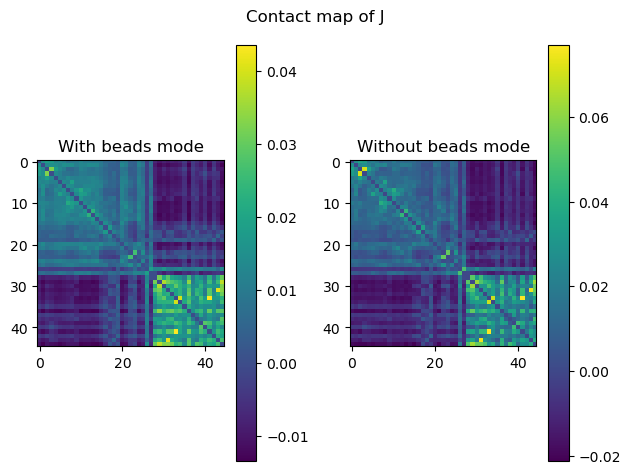

In [84]:
fig, axes = plt.subplots(1,2)

ax = axes[0]
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('With beads mode')

ax = axes[1]
potts_zerosum = model_noc.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('Without beads mode')

fig.suptitle('Contact map of J')

fig.tight_layout()

In [79]:
# compute_energy_beads = lambda x: model_cpu.selection_energy_at_round(x[None, :, :], 1).detach()
# compute_energy_noc = lambda x: model_noc_cpu.selection_energy_at_round(x[None, :, :], 1).detach()

# E_beads = utils.epistasis(compute_energy_beads, wt_oh)
# E_noc = utils.epistasis(compute_energy_noc, wt_oh)

In [85]:
# fig, axes = plt.subplots(1,2)

# ax = axes[0]
# im = ax.imshow(selex_dca.get_contact_map(E_beads))
# # im.set_clim(-0.05, 0.085)
# plt.colorbar(im)
# ax.set_title('With beads mode')

# ax = axes[1]
# im = ax.imshow(selex_dca.get_contact_map(E_noc))
# # im.set_clim(-0.05, 0.085)
# plt.colorbar(im)
# ax.set_title('Without beads mode')

# fig.suptitle('Epistasis')

# fig.tight_layout()

In [174]:
x = sequences_oh[0]
logps = - model.selection_energy_at_round(x, 1)

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [127]:
batches = [next(iter(dl)).to(torch.device) for dl in data_loaders]
selection_round = 1

In [129]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

In [147]:
x_ = torch.ones(L, dtype=int)
y_ = 0 * torch.ones(L, dtype=int)
hamming(one_hot(x_, num_classes=2), one_hot(y_, num_classes=2))

tensor(45, dtype=torch.int32)

In [173]:
d = 3
hd == d

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [171]:
t = 0
x = batches[t]
hd = hamming(wt_oh.to(x.device), x)
logps = - model.selection_energy_at_round(x, selection_round)
deltas = torch.zeros_like(logps)
for d in range(0, L+1):
    idx = (hd == d).to(device)
    logpd = logps[idx].mean()
    deltas[idx] = logps[idx] - logpd

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [168]:
d = 3
logps[hd == d].mean()

tensor(-4.0318, device='cuda:0', grad_fn=<MeanBackward0>)

In [126]:
for t in range(n_rounds):
    x = batches[t]
    logps = - model.selection_energy_at_round(x, selection_round)

In [161]:
pd[hd]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)